# Hierarchies in Synergos Archive

In Synergos, all payloads are arranged in hierarchies, allowing levelled access of any record type across the entire grid. This enhances data management procedures, since users of Synergos Archive have the ability to mask data by using the correct record level. This simplifies the integration with Synergos REST for inter-component compatibility.

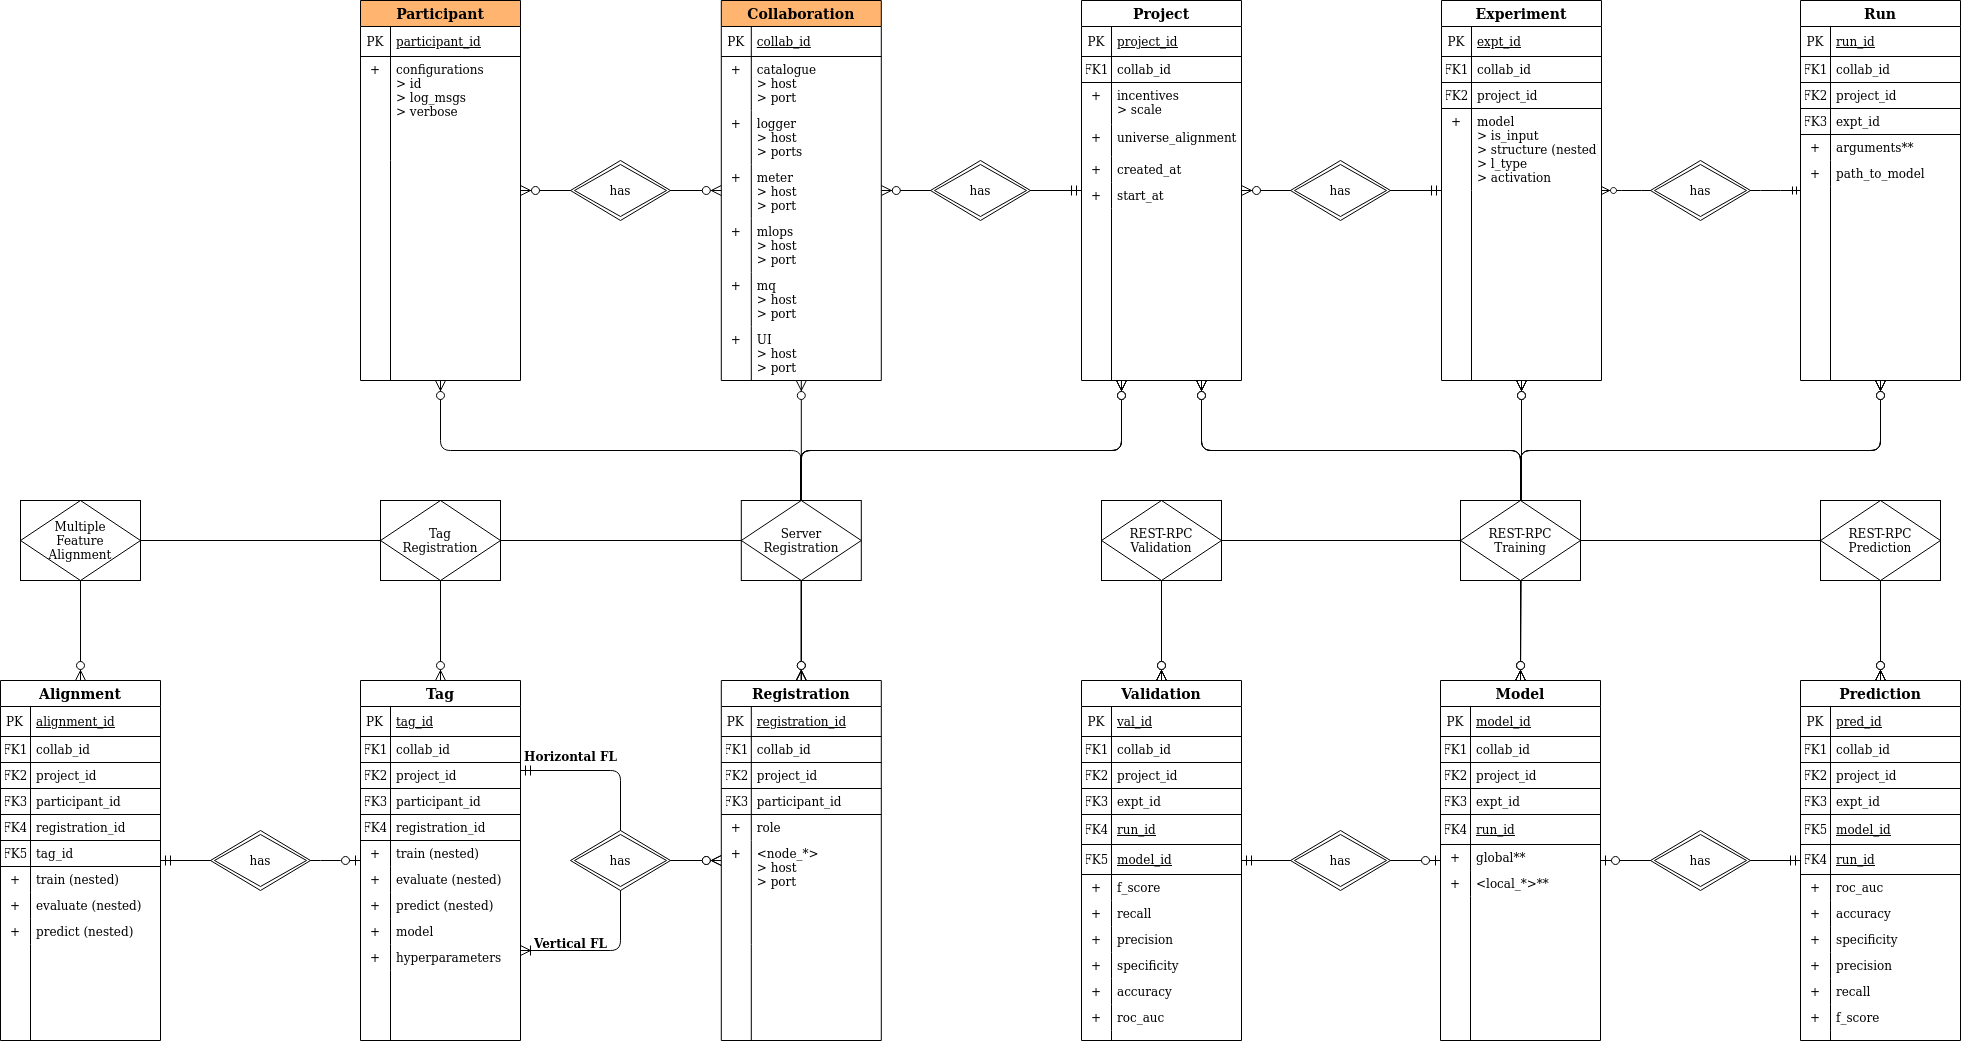

In this notebook, we will be exploring the different hierarchies involved, namely Orchestrator-driven archives & Participant-driven archives, and how they enable intrinsic data management from a simple Document database, currently governed by TinyDB.

In [1]:
#!/usr/bin/env python

####################
# Required Modules #
####################

# Generic/Built-in
import os
import random
from pathlib import Path
from typing import Dict

# Libs
import tinydb
from IPython.display import display, Image

# Custom
from generators import generate_database
from synarchive.connection import (
    CollaborationRecords, ProjectRecords, ExperimentRecords, RunRecords,
    ParticipantRecords, RegistrationRecords, TagRecords
)
from synarchive.training import AlignmentRecords, ModelRecords
from synarchive.evaluation import ValidationRecords, PredictionRecords, MLFRecords

To better understand the true nature of these hierarchies, it is best to abstract out the complexities of system orchestration within Synergos, and just observe the structures themselves. As such, the subsequent cells will serve to simulate a database that would be generated within a real world federated combination.

In [2]:
##################
# Configurations #
##################

# Remember to delete "simulated_database.json" before re-running, 
# otherwise previous generations will stack up and raise unnessary errors

### <-------------------- Modify where necessary --------------------> ###
COLLAB_COUNT = 2
PROJECT_COUNT = 2
EXPT_COUNT = 2
RUN_COUNT = 2
PARTICIPANT_COUNT = 3
### <-------------------- Modification stops here -------------------> ###

DB_PATH = generate_database(
    collabs=COLLAB_COUNT,
    projects=PROJECT_COUNT,
    experiments=EXPT_COUNT,
    runs=RUN_COUNT,
    participants=PARTICIPANT_COUNT
)

# Orchestrator-dependent archives
collab_records = CollaborationRecords(db_path=DB_PATH)
project_records = ProjectRecords(db_path=DB_PATH)
expt_records = ExperimentRecords(db_path=DB_PATH)
run_records = RunRecords(db_path=DB_PATH)
model_records = ModelRecords(db_path=DB_PATH)
val_records = ValidationRecords(db_path=DB_PATH)
pred_records = PredictionRecords(db_path=DB_PATH)

# Participant-dependent archives
participant_records = ParticipantRecords(db_path=DB_PATH)
registration_records = RegistrationRecords(db_path=DB_PATH)
tag_records = TagRecords(db_path=DB_PATH)
alignment_records = AlignmentRecords(db_path=DB_PATH)

# Miscellaneous archives
mlf_records = MLFRecords(db_path=DB_PATH)

ARCHIVE_MAPPINGS = {
    # Orchestrator-dependent
    'collaboration': collab_records,
    'project': project_records,
    'experiment': expt_records,
    'run': run_records,
    'model': model_records,
    'validation': val_records,
    'prediction': pred_records,

    # Participant-dependent
    'participant': participant_records,
    'registration': registration_records,
    'tag': tag_records,
    'alignment': alignment_records,

    # Misc
    "mlflow": mlf_records
}

With the `simulated_database.json` generated, we can start looking into the hierarchies.

## 1. Accessing Archival Hierarchies

In [3]:
###########
# Helpers #
###########

def enumerate_archival_relationships(
    record: tinydb.database.Document, 
    r_type: str
) -> None:
    """ Lists out all relationships that the specified record has 
        enforced w.r.t its downstream hierarchies.
    
    Args:
        record (tinydb.database.Document): Record to be analysed
        r_type (str): Type of record specified
    """
    selected_record_key = record.get('key')
    
    archive = ARCHIVE_MAPPINGS.get(r_type)
    full_record = archive.read(**selected_record_key)
    
    record_relations = full_record.get('relations')
    for subject, records in record_relations.items():
        print(f"Subject accessible from {r_type.capitalize()} - {subject:13}: {len(records)}")
        
    return selected_record_key

### A. Orchestrator-dependent Archives

Archives under this section are managed by the trusted third party (TTP), and so, it is important that the hierarchy created allows the TTP to access all necessary metadata required to orchestrate federated cycles WITHOUT violating federated privacy. 

#### A1. Collaboration

A collaboration is at the heart of the payload hierarchy. It will be used by the TTP admin to aquire ALL metadata organised across the Synergos grid, with the exception of personal participant declarations. All accessible hierarchies are accessible through the `relations` key.

In [4]:
detected_collab_count = len(collab_records.read_all())
assert detected_collab_count == COLLAB_COUNT

print("No .of collaborations detected:", detected_collab_count)

No .of collaborations detected: 2


In [5]:
selected_collaboration = random.choice(collab_records.read_all())

enumerate_archival_relationships(selected_collaboration, "collaboration")

Subject accessible from Collaboration - Project      : 2
Subject accessible from Collaboration - Experiment   : 4
Subject accessible from Collaboration - Run          : 8
Subject accessible from Collaboration - Registration : 6
Subject accessible from Collaboration - Tag          : 6
Subject accessible from Collaboration - Alignment    : 6
Subject accessible from Collaboration - Model        : 8
Subject accessible from Collaboration - Validation   : 24
Subject accessible from Collaboration - Prediction   : 24


{'collab_id': 'COLLAB_1-5363911b-4ee4-4138-b875-bfada9f8cd51'}

Notice that TTP has access to the necessary participants' registrations and tags, both of which are essential for establishing and aligning the Synergos grid. These complex mappings are enforced easily in Synergos Archives.

In [6]:
selected_project = random.choice(selected_collaboration.get('relations').get('Project'))
selected_project

{'created_at': datetime.datetime(2021, 3, 18, 16, 33, 40),
 'incentives': {},
 'key': {'collab_id': 'COLLAB_1-5363911b-4ee4-4138-b875-bfada9f8cd51',
  'project_id': 'PROJECT_0-7f5d5168-e472-4df2-b535-67e6c9b9c780'},
 'start_at': datetime.datetime(2021, 4, 10, 22, 33, 40),
 'universe_alignment': []}

In [7]:
selected_expt = random.choice(selected_collaboration.get('relations').get('Experiment'))
selected_expt

{'created_at': datetime.datetime(2021, 3, 18, 16, 33, 41),
 'key': {'collab_id': 'COLLAB_1-5363911b-4ee4-4138-b875-bfada9f8cd51',
  'expt_id': 'EXPT_1-cb48a3c6-bded-48fa-8e1e-0689c7debb48',
  'project_id': 'PROJECT_1-ead2ebb6-bf9e-44d1-b6d8-5a61ddb95f0e'},
 'model': [{'activation': 'sigmoid',
   'is_input': True,
   'l_type': 'linear',
   'structure': {'bias': True, 'in_features': 40, 'out_features': 76}}]}

In [8]:
selected_run = random.choice(selected_collaboration.get('relations').get('Run'))
selected_run

{'base_lr': 0.5739144999531824,
 'base_momentum': 0.8640960275438389,
 'batch_size': 732,
 'created_at': datetime.datetime(2021, 3, 18, 16, 33, 41),
 'cumulative_delta': True,
 'cycle_momentum': True,
 'dampening': 0.15465155767019323,
 'delta': 0.9447315170874879,
 'epochs': 45,
 'gamma': 0.7387617934908884,
 'input_size': 556,
 'is_condensed': True,
 'key': {'collab_id': 'COLLAB_1-5363911b-4ee4-4138-b875-bfada9f8cd51',
  'expt_id': 'EXPT_1-cb48a3c6-bded-48fa-8e1e-0689c7debb48',
  'project_id': 'PROJECT_1-ead2ebb6-bf9e-44d1-b6d8-5a61ddb95f0e',
  'run_id': 'RUN_1-bb478877-14e5-467b-b5ad-5a7d4ab8eb01'},
 'l1_lambda': 0.34138214999291017,
 'l2_lambda': 0.08991420067622291,
 'last_epoch': 2,
 'lr': 0.24703104024421474,
 'lr_decay': 0.3904615101037202,
 'max_lr': 0.9648349075015858,
 'max_momentum': 0.020675045979785756,
 'mode': 'triangular',
 'mu': 0.9878904874638681,
 'output_size': 17,
 'patience': 4,
 'precision_fractional': 6,
 'reduction': 'mean',
 'rounds': 94,
 'scale_mode': 'iter

In [9]:
selected_model = random.choice(selected_collaboration.get('relations').get('Model'))
selected_model

{'created_at': datetime.datetime(2021, 3, 18, 16, 33, 44),
 'global': {'checkpoints': {'round_0': {'epoch_0': {'loss_history': '/ttp/outputs/test_project_1/test_experiment/test_run/checkpoints/round_0/epoch_0/global_loss_history.json',
     'path': '/ttp/outputs/test_project_1/test_experiment/test_run/checkpoints/round_0/epoch_0/global_model.pt'},
    'epoch_1': {'loss_history': '/ttp/outputs/test_project_1/test_experiment/test_run/checkpoints/round_0/epoch_1/global_loss_history.json',
     'path': '/ttp/outputs/test_project_1/test_experiment/test_run/checkpoints/round_0/epoch_1/global_model.pt'}},
   'round_1': {'epoch_0': {'loss_history': '/ttp/outputs/test_project_1/test_experiment/test_run/checkpoints/round_1/epoch_0/global_loss_history.json',
     'path': '/ttp/outputs/test_project_1/test_experiment/test_run/checkpoints/round_1/epoch_0/global_model.pt'},
    'epoch_1': {'loss_history': '/ttp/outputs/test_project_1/test_experiment/test_run/checkpoints/round_1/epoch_1/global_loss_hi

In [10]:
selected_validation = random.choice(selected_collaboration.get('relations').get('Validation'))
selected_validation

{'created_at': datetime.datetime(2021, 3, 18, 16, 33, 44),
 'evaluate': {'res_path': '/worker/outputs/test_collaboration/test_project/test_experiment/test_run/evaluate/inference_statistics_evaluate.json',
  'statistics': {'FDRs': [0.5107510752300909],
   'FNRs': [0.891127093447162],
   'FNs': [186],
   'FPRs': [0.9733357881225865],
   'FPs': [1973],
   'NPVs': [0.3944567498426782],
   'PPVs': [0.8376391853333611],
   'TNRs': [0.38299216914784406],
   'TNs': [2704],
   'TPRs': [0.32014419619013446],
   'TPs': [951],
   'accuracy': [0.0746720226015285],
   'f_score': [0.8797534970887131],
   'pr_auc_score': [0.3639508240356264],
   'roc_auc_score': [0.2942169436847063]}},
 'key': {'collab_id': 'COLLAB_1-5363911b-4ee4-4138-b875-bfada9f8cd51',
  'expt_id': 'EXPT_0-eb7c9ad2-c974-437e-99ef-bdcbb9eddb7c',
  'participant_id': 'PARTICIPANT_0-ef2daafb-3bf8-4540-a7c7-bb80aa8469e4',
  'project_id': 'PROJECT_1-ead2ebb6-bf9e-44d1-b6d8-5a61ddb95f0e',
  'run_id': 'RUN_0-15914eb0-aa6c-4f50-ade0-316677f

In [11]:
selected_prediction = random.choice(selected_collaboration.get('relations').get('Prediction'))
selected_prediction

{'created_at': datetime.datetime(2021, 3, 18, 16, 33, 45),
 'key': {'collab_id': 'COLLAB_1-5363911b-4ee4-4138-b875-bfada9f8cd51',
  'expt_id': 'EXPT_1-cb48a3c6-bded-48fa-8e1e-0689c7debb48',
  'participant_id': 'PARTICIPANT_1-0ae37cdb-9c60-4237-8bae-010c34e132a4',
  'project_id': 'PROJECT_1-ead2ebb6-bf9e-44d1-b6d8-5a61ddb95f0e',
  'run_id': 'RUN_1-bb478877-14e5-467b-b5ad-5a7d4ab8eb01'},
 'link': {'pred_id': 'b5299d5f880711eb97e734e12ddd1e7c'},
 'predict': {'res_path': '/worker/outputs/test_collaboration/test_project/test_experiment/test_run/predict/inference_statistics_predict.json',
  'statistics': {'FDRs': [0.5410318589240922, 0.7637582782965446],
   'FNRs': [0.7863335166720304, 0.1838972714776913],
   'FNs': [2491, 2509],
   'FPRs': [0.11163444611452189, 0.36453707189653595],
   'FPs': [68, 3533],
   'NPVs': [0.5475289155776948, 0.9467274349286625],
   'PPVs': [0.446387701877597, 0.27990671340031414],
   'TNRs': [0.9464202807825843, 0.8848683889738634],
   'TNs': [1600, 3701],
   'TP

#### A2. Project

In [12]:
detected_project_count = len(project_records.read_all())
assert detected_project_count == COLLAB_COUNT * PROJECT_COUNT

print("No .of projects detected:", detected_project_count)

No .of projects detected: 4


In [13]:
enumerate_archival_relationships(selected_project, "project")

Subject accessible from Project - Experiment   : 2
Subject accessible from Project - Run          : 4
Subject accessible from Project - Registration : 3
Subject accessible from Project - Tag          : 3
Subject accessible from Project - Alignment    : 3
Subject accessible from Project - Model        : 4
Subject accessible from Project - Validation   : 12
Subject accessible from Project - Prediction   : 12


{'collab_id': 'COLLAB_1-5363911b-4ee4-4138-b875-bfada9f8cd51',
 'project_id': 'PROJECT_0-7f5d5168-e472-4df2-b535-67e6c9b9c780'}

#### A3. Experiment

In [14]:
detected_expt_count = len(expt_records.read_all())
assert detected_expt_count == COLLAB_COUNT * PROJECT_COUNT * EXPT_COUNT

print("No .of experiments detected:", detected_expt_count)

No .of experiments detected: 8


In [15]:
enumerate_archival_relationships(selected_expt, "experiment")

Subject accessible from Experiment - Run          : 2
Subject accessible from Experiment - Model        : 2
Subject accessible from Experiment - Validation   : 6
Subject accessible from Experiment - Prediction   : 6


{'collab_id': 'COLLAB_1-5363911b-4ee4-4138-b875-bfada9f8cd51',
 'expt_id': 'EXPT_1-cb48a3c6-bded-48fa-8e1e-0689c7debb48',
 'project_id': 'PROJECT_1-ead2ebb6-bf9e-44d1-b6d8-5a61ddb95f0e'}

#### A4. Run

In [16]:
detected_run_count = len(run_records.read_all())
assert detected_run_count == COLLAB_COUNT * PROJECT_COUNT * EXPT_COUNT * RUN_COUNT

print("No .of runs detected:", detected_run_count)

No .of runs detected: 16


In [17]:
enumerate_archival_relationships(selected_run, "run")

Subject accessible from Run - Model        : 1
Subject accessible from Run - Validation   : 3
Subject accessible from Run - Prediction   : 3


{'collab_id': 'COLLAB_1-5363911b-4ee4-4138-b875-bfada9f8cd51',
 'expt_id': 'EXPT_1-cb48a3c6-bded-48fa-8e1e-0689c7debb48',
 'project_id': 'PROJECT_1-ead2ebb6-bf9e-44d1-b6d8-5a61ddb95f0e',
 'run_id': 'RUN_1-bb478877-14e5-467b-b5ad-5a7d4ab8eb01'}

---

### B. Participant-dependent Archives

Archives under this section are managed by the participant themselves, while indirectly through Synergos REST,  and so, it is important that the hierarchy created allows the participant to easily manage all necessary metadata required. 

#### B1. Participant

A participant record is the root for a series of associated records that links to a collaboration and their projects. All accessible hierarchies are accessible through the `relations` key.

In [18]:
detected_participant_count = len(participant_records.read_all())
assert detected_participant_count == PARTICIPANT_COUNT

print("No .of participants detected:", detected_participant_count)

No .of participants detected: 3


In [19]:
selected_participant = random.choice(participant_records.read_all())

enumerate_archival_relationships(selected_participant, "participant")

Subject accessible from Participant - Registration : 4
Subject accessible from Participant - Tag          : 4
Subject accessible from Participant - Alignment    : 4
Subject accessible from Participant - Validation   : 16
Subject accessible from Participant - Prediction   : 16


{'participant_id': 'PARTICIPANT_1-0ae37cdb-9c60-4237-8bae-010c34e132a4'}

Notice that participants have access to their respective validation and inference statistics. These complex mappings are enforced easily in Synergos Archives.

In [20]:
selected_registration = random.choice(selected_participant.get('relations').get('Registration'))
selected_registration

{'created_at': datetime.datetime(2021, 3, 18, 16, 33, 41),
 'key': {'collab_id': 'COLLAB_0-d5a44a07-42af-4a8b-ae32-4fb6e2d42dd3',
  'participant_id': 'PARTICIPANT_1-0ae37cdb-9c60-4237-8bae-010c34e132a4',
  'project_id': 'PROJECT_1-178f2d4b-b830-4a38-8cff-ae4846391171'},
 'link': {'registration_id': 'b2d7ad23880711eb97e734e12ddd1e7c'},
 'node_0': {'host': '962.51.693.686', 'port': 35943},
 'node_1': {'host': '888.70.463.310', 'port': 17467},
 'node_2': {'host': '854.808.786.96', 'port': 16037},
 'node_3': {'host': '178.840.809.858', 'port': 5012},
 'node_4': {'host': '335.514.171.219', 'port': 25273},
 'node_5': {'host': '884.650.827.114', 'port': 31886},
 'node_6': {'host': '139.341.154.766', 'port': 53071},
 'node_7': {'host': '688.242.610.266', 'port': 50846},
 'role': 'guest'}

In [21]:
selected_tag = random.choice(selected_participant.get('relations').get('Tag'))
selected_tag

{'created_at': datetime.datetime(2021, 3, 18, 16, 33, 41),
 'evaluate': [['test_dataset', 'set_2', 'version_8']],
 'key': {'collab_id': 'COLLAB_0-d5a44a07-42af-4a8b-ae32-4fb6e2d42dd3',
  'participant_id': 'PARTICIPANT_1-0ae37cdb-9c60-4237-8bae-010c34e132a4',
  'project_id': 'PROJECT_1-178f2d4b-b830-4a38-8cff-ae4846391171'},
 'link': {'registration_id': 'b2d7ad23880711eb97e734e12ddd1e7c',
  'tag_id': 'b2d7ad24880711eb97e734e12ddd1e7c'},
 'predict': [['test_dataset', 'set_8', 'version_3'],
  ['test_dataset', 'set_10', 'version_3'],
  ['test_dataset', 'set_3', 'version_5'],
  ['test_dataset', 'set_8', 'version_8'],
  ['test_dataset', 'set_9', 'version_3'],
  ['test_dataset', 'set_10', 'version_9']],
 'train': [['test_dataset', 'set_1', 'version_2']]}

In [22]:
selected_alignment = random.choice(selected_participant.get('relations').get('Alignment'))
selected_alignment

{'created_at': datetime.datetime(2021, 3, 18, 16, 33, 41),
 'evaluate': {'X': [135, 262, 370, 383, 570, 586], 'y': [0]},
 'key': {'collab_id': 'COLLAB_0-d5a44a07-42af-4a8b-ae32-4fb6e2d42dd3',
  'participant_id': 'PARTICIPANT_1-0ae37cdb-9c60-4237-8bae-010c34e132a4',
  'project_id': 'PROJECT_1-178f2d4b-b830-4a38-8cff-ae4846391171'},
 'link': {'alignment_id': 'b2d7ad25880711eb97e734e12ddd1e7c',
  'registration_id': 'b2d7ad23880711eb97e734e12ddd1e7c',
  'tag_id': 'b2d7ad24880711eb97e734e12ddd1e7c'},
 'predict': {'X': [37,
   54,
   55,
   66,
   81,
   82,
   89,
   110,
   131,
   131,
   153,
   155,
   168,
   174,
   182,
   199,
   205,
   212,
   227,
   232,
   244,
   283,
   304,
   344,
   361,
   362,
   368,
   377,
   380,
   393,
   394,
   397,
   416,
   436,
   461,
   477,
   487,
   491,
   503,
   522,
   563,
   566,
   604,
   654,
   654,
   658,
   671,
   690,
   731,
   737,
   754,
   758,
   769,
   776,
   796,
   798,
   802,
   808,
   811,
   819,
   827,
  

#### B2. Registration

In [23]:
detected_registration_count = len(registration_records.read_all())
assert detected_registration_count == COLLAB_COUNT * PROJECT_COUNT * PARTICIPANT_COUNT

print("No .of registrations detected:", detected_registration_count)

No .of registrations detected: 12


In [24]:
enumerate_archival_relationships(selected_registration, "registration")

Subject accessible from Registration - Tag          : 1
Subject accessible from Registration - Alignment    : 1


{'collab_id': 'COLLAB_0-d5a44a07-42af-4a8b-ae32-4fb6e2d42dd3',
 'participant_id': 'PARTICIPANT_1-0ae37cdb-9c60-4237-8bae-010c34e132a4',
 'project_id': 'PROJECT_1-178f2d4b-b830-4a38-8cff-ae4846391171'}

#### B3. Tag

In [25]:
detected_tag_count = len(tag_records.read_all())
assert detected_tag_count == COLLAB_COUNT * PROJECT_COUNT * PARTICIPANT_COUNT

print("No .of tags detected:", detected_tag_count)

No .of tags detected: 12


In [26]:
enumerate_archival_relationships(selected_tag, "tag")

Subject accessible from Tag - Alignment    : 1


{'collab_id': 'COLLAB_0-d5a44a07-42af-4a8b-ae32-4fb6e2d42dd3',
 'participant_id': 'PARTICIPANT_1-0ae37cdb-9c60-4237-8bae-010c34e132a4',
 'project_id': 'PROJECT_1-178f2d4b-b830-4a38-8cff-ae4846391171'}

#### B4. Alignment

In [27]:
detected_alignment_count = len(alignment_records.read_all())
assert detected_alignment_count == COLLAB_COUNT * PROJECT_COUNT * PARTICIPANT_COUNT

print("No .of alignments detected:", detected_alignment_count)

No .of alignments detected: 12


In [28]:
enumerate_archival_relationships(selected_alignment, "alignment") # No subject accessible

{'collab_id': 'COLLAB_0-d5a44a07-42af-4a8b-ae32-4fb6e2d42dd3',
 'participant_id': 'PARTICIPANT_1-0ae37cdb-9c60-4237-8bae-010c34e132a4',
 'project_id': 'PROJECT_1-178f2d4b-b830-4a38-8cff-ae4846391171'}

Notice that every association record - Registrations, Tags & Alignments - have exactly the same keys, but are linked up by the `link` field. This enforces the upstream hierarchy tracking: `registration <= tag <= alignment.` 

---

## 2. Removing Archival Hierarchies

After deleting a registration record, everything downstream gets destroyed.

In [29]:
###########
# Helpers #
###########

def enumerate_deleted_relationships(
    record: tinydb.database.Document, 
    r_type: str
) -> None:
    """ Lists out all relationships that the deleted record has 
        enforced w.r.t its downstream hierarchies, and counted
        the total records deleted per subject.
    
    Args:
        record (tinydb.database.Document): Record to be analysed
        r_type (str): Type of record specified
    """
    deleted_relations = record.get('relations')

    deleted_relation_counts = {}
    for subject, records in deleted_relations.items():
        for record in records:
            curr_archive = ARCHIVE_MAPPINGS.get(subject.lower())
            curr_key = record.get('key')
            retrieved_record = curr_archive.read(**curr_key)
            is_deleted = (retrieved_record is None)
            deleted_relation_counts[subject] = deleted_relation_counts.get(subject, 0) + 1
            print("-"*90)
            print(f"Subject {subject}:\n{curr_key}\nIs record deleted? {is_deleted}")
            
    return deleted_relation_counts


def parse_deleted_counts(deleted_counts: Dict[str, int]):
    """
    """
    for subject, total_count in deleted_counts.items():
        print(f"Deleted counts of Subject {subject:13}: {total_count}")

### A.  Orchestrator-dependent Archives

In [30]:
print("Before deletion, no. of collaborations detected:", len(collab_records.read_all()))

Before deletion, no. of collaborations detected: 2


In [31]:
target_collaboration = random.choice(collab_records.read_all())

target_collab_key = enumerate_archival_relationships(
    target_collaboration, 
    "collaboration"
)
target_collab_key

Subject accessible from Collaboration - Project      : 2
Subject accessible from Collaboration - Experiment   : 4
Subject accessible from Collaboration - Run          : 8
Subject accessible from Collaboration - Registration : 6
Subject accessible from Collaboration - Tag          : 6
Subject accessible from Collaboration - Alignment    : 6
Subject accessible from Collaboration - Model        : 8
Subject accessible from Collaboration - Validation   : 24
Subject accessible from Collaboration - Prediction   : 24


{'collab_id': 'COLLAB_1-5363911b-4ee4-4138-b875-bfada9f8cd51'}

In [32]:
deleted_collab = collab_records.delete(**target_collab_key)
deleted_collab

{'catalogue_host': '573.472.984.55',
 'catalogue_port': 58217,
 'created_at': datetime.datetime(2021, 3, 18, 16, 33, 40),
 'key': {'collab_id': 'COLLAB_1-5363911b-4ee4-4138-b875-bfada9f8cd51'},
 'logger_host': '458.771.542.434',
 'logger_ports': {'director': 40340,
  'sysmetrics': 6317,
  'ttp': 63853,
  'worker': 31970},
 'meter_host': '233.295.557.492',
 'meter_port': 51320,
 'mlops_host': '242.877.1000.677',
 'mlops_port': 52959,
 'mq_host': '198.620.570.638',
 'mq_port': 38508,
 'ui_host': '867.79.429.438',
 'ui_port': 46455,
 'relations': {'Project': [{'created_at': datetime.datetime(2021, 3, 18, 16, 33, 40),
    'incentives': {},
    'key': {'collab_id': 'COLLAB_1-5363911b-4ee4-4138-b875-bfada9f8cd51',
     'project_id': 'PROJECT_0-7f5d5168-e472-4df2-b535-67e6c9b9c780'},
    'start_at': datetime.datetime(2021, 4, 10, 22, 33, 40),
    'universe_alignment': []},
   {'created_at': datetime.datetime(2021, 3, 18, 16, 33, 40),
    'incentives': {},
    'key': {'collab_id': 'COLLAB_1-53

In [33]:
print("After deletion, no. of collaborations detected:", len(collab_records.read_all()))

After deletion, no. of collaborations detected: 1


In [34]:
deleted_collab_relation_counts = enumerate_deleted_relationships(
    deleted_collab, 
    "collaboration"
)

------------------------------------------------------------------------------------------
Subject Project:
{'collab_id': 'COLLAB_1-5363911b-4ee4-4138-b875-bfada9f8cd51', 'project_id': 'PROJECT_0-7f5d5168-e472-4df2-b535-67e6c9b9c780'}
Is record deleted? True
------------------------------------------------------------------------------------------
Subject Project:
{'collab_id': 'COLLAB_1-5363911b-4ee4-4138-b875-bfada9f8cd51', 'project_id': 'PROJECT_1-ead2ebb6-bf9e-44d1-b6d8-5a61ddb95f0e'}
Is record deleted? True
------------------------------------------------------------------------------------------
Subject Experiment:
{'collab_id': 'COLLAB_1-5363911b-4ee4-4138-b875-bfada9f8cd51', 'expt_id': 'EXPT_0-5a898f47-6e9f-44aa-b4e7-83fef70186a5', 'project_id': 'PROJECT_0-7f5d5168-e472-4df2-b535-67e6c9b9c780'}
Is record deleted? True
------------------------------------------------------------------------------------------
Subject Experiment:
{'collab_id': 'COLLAB_1-5363911b-4ee4-4138-b875-bfa

------------------------------------------------------------------------------------------
Subject Alignment:
{'collab_id': 'COLLAB_1-5363911b-4ee4-4138-b875-bfada9f8cd51', 'participant_id': 'PARTICIPANT_0-ef2daafb-3bf8-4540-a7c7-bb80aa8469e4', 'project_id': 'PROJECT_0-7f5d5168-e472-4df2-b535-67e6c9b9c780'}
Is record deleted? True
------------------------------------------------------------------------------------------
Subject Alignment:
{'collab_id': 'COLLAB_1-5363911b-4ee4-4138-b875-bfada9f8cd51', 'participant_id': 'PARTICIPANT_0-ef2daafb-3bf8-4540-a7c7-bb80aa8469e4', 'project_id': 'PROJECT_1-ead2ebb6-bf9e-44d1-b6d8-5a61ddb95f0e'}
Is record deleted? True
------------------------------------------------------------------------------------------
Subject Alignment:
{'collab_id': 'COLLAB_1-5363911b-4ee4-4138-b875-bfada9f8cd51', 'participant_id': 'PARTICIPANT_1-0ae37cdb-9c60-4237-8bae-010c34e132a4', 'project_id': 'PROJECT_0-7f5d5168-e472-4df2-b535-67e6c9b9c780'}
Is record deleted? True
-

------------------------------------------------------------------------------------------
Subject Validation:
{'collab_id': 'COLLAB_1-5363911b-4ee4-4138-b875-bfada9f8cd51', 'expt_id': 'EXPT_1-cb48a3c6-bded-48fa-8e1e-0689c7debb48', 'participant_id': 'PARTICIPANT_2-c763e760-7238-4f35-8f20-b3c38da13d67', 'project_id': 'PROJECT_1-ead2ebb6-bf9e-44d1-b6d8-5a61ddb95f0e', 'run_id': 'RUN_0-6fc0275d-260a-44fd-a031-c03489210a7e'}
Is record deleted? True
------------------------------------------------------------------------------------------
Subject Validation:
{'collab_id': 'COLLAB_1-5363911b-4ee4-4138-b875-bfada9f8cd51', 'expt_id': 'EXPT_1-cb48a3c6-bded-48fa-8e1e-0689c7debb48', 'participant_id': 'PARTICIPANT_0-ef2daafb-3bf8-4540-a7c7-bb80aa8469e4', 'project_id': 'PROJECT_1-ead2ebb6-bf9e-44d1-b6d8-5a61ddb95f0e', 'run_id': 'RUN_1-bb478877-14e5-467b-b5ad-5a7d4ab8eb01'}
Is record deleted? True
------------------------------------------------------------------------------------------
Subject Valid

In [35]:
parse_deleted_counts(deleted_collab_relation_counts)

Deleted counts of Subject Project      : 2
Deleted counts of Subject Experiment   : 4
Deleted counts of Subject Run          : 8
Deleted counts of Subject Registration : 6
Deleted counts of Subject Tag          : 6
Deleted counts of Subject Alignment    : 6
Deleted counts of Subject Model        : 8
Deleted counts of Subject Validation   : 24
Deleted counts of Subject Prediction   : 24


### B. Participant-dependent Archives

In [36]:
print("Before deletion, no. of participants detected:", len(participant_records.read_all()))

Before deletion, no. of participants detected: 3


In [37]:
target_participant = random.choice(participant_records.read_all())

target_participant_key = enumerate_archival_relationships(
    target_participant, 
    "participant"
)
target_participant_key

Subject accessible from Participant - Registration : 2
Subject accessible from Participant - Tag          : 2
Subject accessible from Participant - Alignment    : 2
Subject accessible from Participant - Validation   : 8
Subject accessible from Participant - Prediction   : 8


{'participant_id': 'PARTICIPANT_0-ef2daafb-3bf8-4540-a7c7-bb80aa8469e4'}

In [38]:
deleted_participant = participant_records.delete(**target_participant_key)
deleted_participant

{'created_at': datetime.datetime(2021, 3, 18, 16, 33, 41),
 'f_port': 26165,
 'host': '315.956.942.262',
 'id': 'PARTICIPANT_0-ef2daafb-3bf8-4540-a7c7-bb80aa8469e4',
 'key': {'participant_id': 'PARTICIPANT_0-ef2daafb-3bf8-4540-a7c7-bb80aa8469e4'},
 'log_msgs': False,
 'port': 24982,
 'verbose': True,
 'relations': {'Registration': [{'created_at': datetime.datetime(2021, 3, 18, 16, 33, 41),
    'key': {'collab_id': 'COLLAB_0-d5a44a07-42af-4a8b-ae32-4fb6e2d42dd3',
     'participant_id': 'PARTICIPANT_0-ef2daafb-3bf8-4540-a7c7-bb80aa8469e4',
     'project_id': 'PROJECT_0-b14815e4-124c-4539-a91d-54103f6b5a2b'},
    'link': {'registration_id': 'b2d7ad14880711eb97e734e12ddd1e7c'},
    'node_0': {'host': '217.40.227.747', 'port': 18341},
    'node_1': {'host': '759.180.622.154', 'port': 49985},
    'node_2': {'host': '18.435.657.583', 'port': 60825},
    'node_3': {'host': '386.190.933.907', 'port': 57633},
    'node_4': {'host': '959.460.538.485', 'port': 57346},
    'role': 'guest'},
   {'cr

In [39]:
print("After deletion, no. of participants detected:", len(participant_records.read_all()))

After deletion, no. of participants detected: 2


In [40]:
deleted_participant_relation_counts = enumerate_deleted_relationships(
    deleted_participant, 
    "participant"
)

------------------------------------------------------------------------------------------
Subject Registration:
{'collab_id': 'COLLAB_0-d5a44a07-42af-4a8b-ae32-4fb6e2d42dd3', 'participant_id': 'PARTICIPANT_0-ef2daafb-3bf8-4540-a7c7-bb80aa8469e4', 'project_id': 'PROJECT_0-b14815e4-124c-4539-a91d-54103f6b5a2b'}
Is record deleted? True
------------------------------------------------------------------------------------------
Subject Registration:
{'collab_id': 'COLLAB_0-d5a44a07-42af-4a8b-ae32-4fb6e2d42dd3', 'participant_id': 'PARTICIPANT_0-ef2daafb-3bf8-4540-a7c7-bb80aa8469e4', 'project_id': 'PROJECT_1-178f2d4b-b830-4a38-8cff-ae4846391171'}
Is record deleted? True
------------------------------------------------------------------------------------------
Subject Tag:
{'collab_id': 'COLLAB_0-d5a44a07-42af-4a8b-ae32-4fb6e2d42dd3', 'participant_id': 'PARTICIPANT_0-ef2daafb-3bf8-4540-a7c7-bb80aa8469e4', 'project_id': 'PROJECT_0-b14815e4-124c-4539-a91d-54103f6b5a2b'}
Is record deleted? True
-

In [41]:
parse_deleted_counts(deleted_participant_relation_counts)

Deleted counts of Subject Registration : 2
Deleted counts of Subject Tag          : 2
Deleted counts of Subject Alignment    : 2
Deleted counts of Subject Validation   : 8
Deleted counts of Subject Prediction   : 8


As such, these hierarchies demostrate the ease of establishing data control via Synergos Archive, and correspondingly, Synergos itself.